In [75]:
import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg16 import VGG16#, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
from matplotlib.ticker import PercentFormatter
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from livelossplot import PlotLossesKeras
import numpy as np

In [375]:
# Define image dimensions
img_height = 224
img_width = 224
input_shape = (img_height, img_width, 3)

# Set the seed validation
seed_train_validation = 2 # Must be same for train_ds and val_ds
shuffle_value = True # Must be same

# Number of classes
num_classes = 3 

# Set the path for the dataset
train_data_dir = '/Users/jonathanforsyth/Documents/UMass/Machine_Learning/spectra/images/train/'
val_data_dir = '/Users/jonathanforsyth/Documents/UMass/Machine_Learning/spectra/images/validation/'

In [3]:
# Training Dataset
train_ds = keras.utils.image_dataset_from_directory(directory=train_data_dir,
                                                    labels='inferred',
                                                    label_mode='categorical',
                                                    batch_size=101,
                                                    image_size=(img_height, img_width),
                                                    shuffle=shuffle_value, 
                                                    seed = seed_train_validation)

# Validation Dataset
val_ds = keras.utils.image_dataset_from_directory(directory=val_data_dir,
                                                    labels='inferred',
                                                    label_mode='categorical',
                                                    batch_size=53,
                                                    image_size=(img_height, img_width),
                                                    shuffle=shuffle_value, 
                                                    seed = seed_train_validation)

Found 1500 files belonging to 3 classes.
Found 793 files belonging to 3 classes.


2023-04-23 19:13:16.873244: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Build the VGG16 model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape, classes=3)

In [5]:
# Freeze the layers in the VGG16 model
for layer in vgg16_model.layers:
    layer.trainable = False

In [6]:
# Build the final classification layers
model = tf.keras.models.Sequential([
    vgg16_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [7]:
# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [8]:
# Train the model and store the history
history = model.fit(train_ds,
                    epochs=5,
                    validation_data=val_ds)

Epoch 1/5
15/15 [==============================] - 529s 36s/step - loss: 19.1310 - accuracy: 0.4813 - val_loss: 3.1764 - val_accuracy: 0.6255
Epoch 2/5
15/15 [==============================] - 531s 36s/step - loss: 7.5529 - accuracy: 0.5440 - val_loss: 1.7158 - val_accuracy: 0.6066
Epoch 3/5
15/15 [==============================] - 474s 32s/step - loss: 2.9373 - accuracy: 0.6080 - val_loss: 0.8919 - val_accuracy: 0.6633
Epoch 4/5
15/15 [==============================] - 467s 32s/step - loss: 1.2859 - accuracy: 0.5860 - val_loss: 0.7921 - val_accuracy: 0.6040
Epoch 5/5
15/15 [==============================] - 473s 32s/step - loss: 1.0682 - accuracy: 0.6307 - val_loss: 0.8235 - val_accuracy: 0.5977


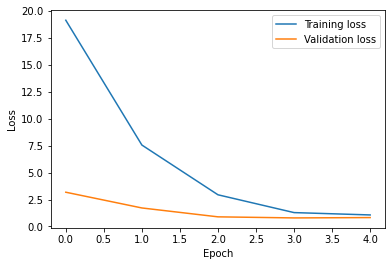

In [9]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

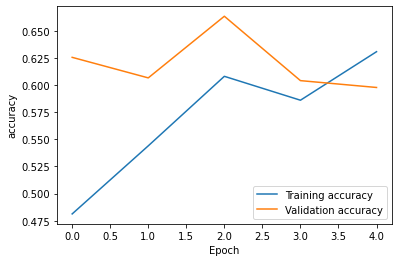

In [10]:
# Plot the training and validation loss over epochs
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [11]:
predictions = np.array([])
labels =  np.array([])
for x, y in train_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
    
cm=tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

3/3 [==============================] - 18s 6s/step


In [32]:
cm[0]

array([293,  86,   4], dtype=int32)

In [67]:
df_cfm = pd.DataFrame(cm)
df_cfm=df_cfm.transpose()
df_cfm

,0,1,2
0,293,40,3
1,86,557,227
2,4,69,221


In [37]:
# This is supposed to be used in the df above, but it's not working atm
names_as_ints=['low complexity (pa 1-8)', 'med complexity (pa 9-14)', 'high complexity (pa 15-23)']

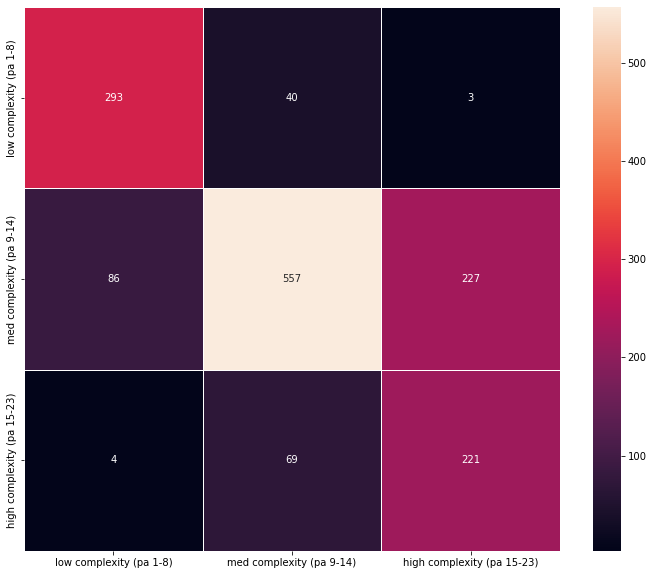

In [70]:
plt.figure(figsize = (12,10))
cfm_plot = sn.heatmap(df_cfm, annot=True, linewidths=.5, fmt='n', xticklabels=names_as_ints, yticklabels=names_as_ints)

(array([336.,   0.,   0.,   0.,   0., 870.,   0.,   0.,   0., 294.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

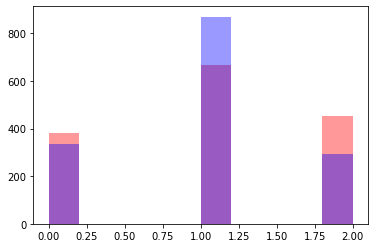

In [64]:
plt.hist(labels, color='red', alpha=.4)
plt.hist(predictions, color='blue', alpha=.4)

(array([   3.,    0.,  267.,    0.,    0., 1071.,    0.,  155.,    0.,
           4.]),
 array([-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <BarContainer object of 10 artists>)

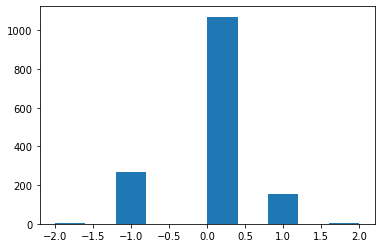

In [50]:
plt.hist(predictions-labels)

In [ ]:
# Define image dimensions
img_height = 224
img_width = 224
input_shape = (img_height, img_width, 3)

# Set the seed validation
seed_train_validation = 2 # Must be same for train_ds and val_ds
shuffle_value = True # Must be same

# Number of classes
num_classes_2 = 23 

# Set the path for the dataset
train_data_dir_2 = '/Users/jonathanforsyth/Documents/UMass/Machine_Learning/spectra/images/train1/'
val_data_dir_2 = '/Users/jonathanforsyth/Documents/UMass/Machine_Learning/spectra/images/validation1/'

In [142]:
# Training Dataset
train_ds_2 = keras.utils.image_dataset_from_directory(directory=train_data_dir_2,
                                                    labels='inferred',
                                                    label_mode='categorical',
                                                    batch_size=101,
                                                    image_size=(img_height, img_width),
                                                    shuffle=shuffle_value, 
                                                    seed = seed_train_validation)

# Validation Dataset
val_ds_2 = keras.utils.image_dataset_from_directory(directory=val_data_dir_2,
                                                    labels='inferred',
                                                    label_mode='categorical',
                                                    batch_size=53,
                                                    image_size=(img_height, img_width),
                                                    shuffle=shuffle_value, 
                                                    seed = seed_train_validation)

Found 1503 files belonging to 23 classes.
Found 794 files belonging to 23 classes.


In [116]:
# Build the final classification layers
model_2 = tf.keras.models.Sequential([
    vgg16_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes_2, activation='softmax')
])

In [117]:
# Compile the model
model_2.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [118]:
# Train the model and store the history
history_2 = model_2.fit(train_ds_2,
                    epochs=5,
                    validation_data=val_ds_2)

Epoch 1/5
15/15 [==============================] - 551s 38s/step - loss: 23.4472 - accuracy: 0.0812 - val_loss: 3.4988 - val_accuracy: 0.1990
Epoch 2/5
15/15 [==============================] - 510s 35s/step - loss: 4.3862 - accuracy: 0.0845 - val_loss: 2.9624 - val_accuracy: 0.1725
Epoch 3/5
15/15 [==============================] - 567s 39s/step - loss: 3.1531 - accuracy: 0.1218 - val_loss: 2.8822 - val_accuracy: 0.1776
Epoch 4/5
15/15 [==============================] - 553s 37s/step - loss: 3.1296 - accuracy: 0.1184 - val_loss: 2.9762 - val_accuracy: 0.1423
Epoch 5/5
15/15 [==============================] - 538s 37s/step - loss: 3.0793 - accuracy: 0.1218 - val_loss: 2.8837 - val_accuracy: 0.1637


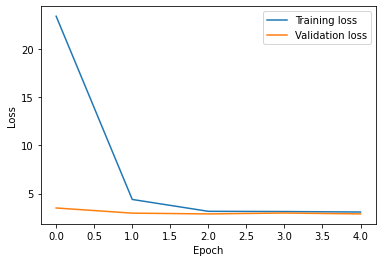

In [119]:
# Plot the training and validation loss over epochs
plt.plot(history_2.history['loss'], label='Training loss')
plt.plot(history_2.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

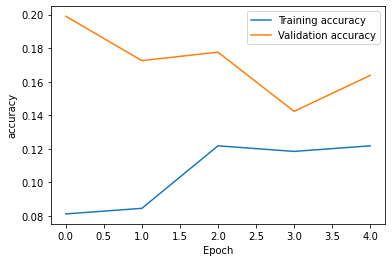

In [120]:
# Plot the training and validation loss over epochs
plt.plot(history_2.history['accuracy'], label='Training accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [127]:
predictions_2 = np.array([])
labels_2 =  np.array([])
for x, y in train_ds_2:
  predictions_2 = np.concatenate([predictions_2, np.argmax(model_2.predict(x), axis = -1)])
  labels_2 = np.concatenate([labels_2, np.argmax(y.numpy(), axis=-1)])
    
cm2=tf.math.confusion_matrix(labels=labels_2, predictions=predictions_2).numpy()

3/3 [==============================] - 19s 6s/step


In [131]:
df_cfm_2=pd.DataFrame(cm2)
df_cfm_2=df_cfm_2.transpose()
df_cfm_2

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,10,13,9,3,5,5,0,0,1,...,0,0,0,0,0,0,0,8,9,13
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,2,0,2,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,81,74,74,79,130,130,96,49,22,...,2,1,0,12,20,41,53,61,63,62
6,0,5,9,14,17,32,55,32,12,3,...,1,0,1,1,3,3,2,8,5,4
7,0,3,3,4,1,17,12,7,2,2,...,0,0,0,1,1,2,3,3,4,1
8,0,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


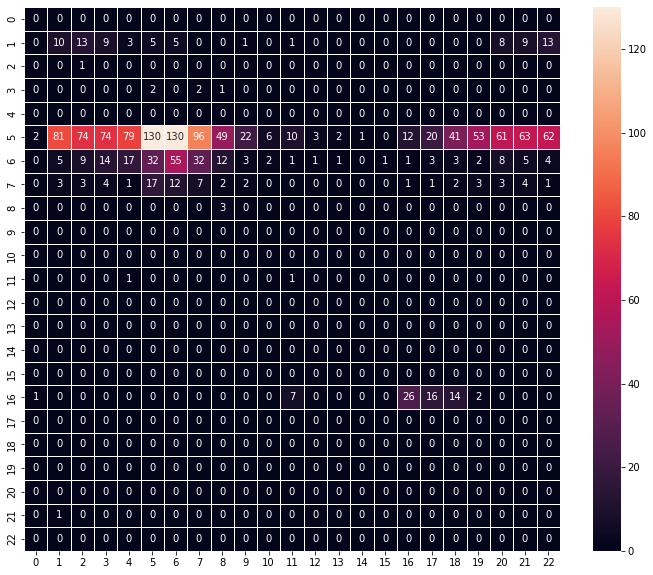

In [132]:
plt.figure(figsize = (12,10))
cfm_plot_2 = sn.heatmap(df_cfm_2, annot=True, linewidths=.5, fmt='n')#, xticklabels=names_as_ints, yticklabels=names_as_ints)

In [185]:
checkpoint_path = "training1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [198]:
# Build the final classification layers
model_3 = tf.keras.models.Sequential([
    vgg16_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes_2, activation='relu')
])

In [200]:
# Compile the model
model_3.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.3, name='Adam'), #, use_ema=True),
                loss=tf.keras.losses.MeanAbsoluteError(), 
                metrics=['accuracy'])

In [201]:
# Train the model and store the history
history_3 = model_3.fit(train_ds_2,
                        epochs=5,
                        validation_data=val_ds_2, 
                        callbacks=[cp_callback])

Epoch 1/5
15/15 [==============================] - ETA: 0s - loss: 0.4226 - accuracy: 0.0060 
Epoch 1: saving model to training1/cp.ckpt
15/15 [==============================] - 586s 40s/step - loss: 0.4226 - accuracy: 0.0060 - val_loss: 0.0435 - val_accuracy: 0.0038
Epoch 2/5
 1/15 [=>............................] - ETA: 6:04 - loss: 0.0435 - accuracy: 0.0000e+00

KeyboardInterrupt: 

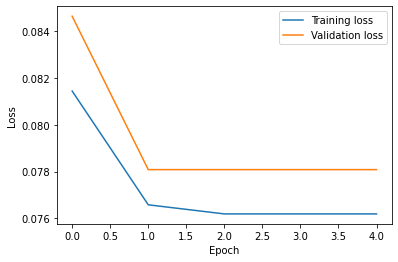

In [ ]:
# Plot the training and validation loss over epochs
plt.plot(history_3.history['loss'], label='Training loss')
plt.plot(history_3.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

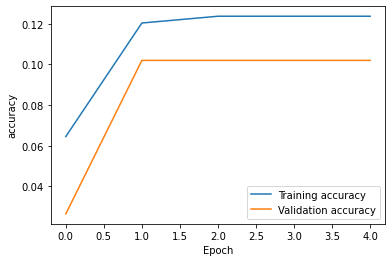

In [172]:
# Plot the training and validation loss over epochs
plt.plot(history_3.history['accuracy'], label='Training accuracy')
plt.plot(history_3.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [173]:
predictions_3 = np.array([])
labels_3 =  np.array([])
for x, y in train_ds_2:
  predictions_3 = np.concatenate([predictions_3, np.argmax(model_3.predict(x), axis = -1)])
  labels_3 = np.concatenate([labels_3, np.argmax(y.numpy(), axis=-1)])

3/3 [==============================] - 19s 6s/step


In [174]:
cm3=tf.math.confusion_matrix(labels=labels_3, predictions=predictions_3).numpy()

In [175]:
df_cfm_3=pd.DataFrame(cm3)
df_cfm_3=df_cfm_3.transpose()
df_cfm_3

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,3,100,100,101,101,186,202,137,67,28,...,3,1,1,40,40,60,60,80,81,80
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


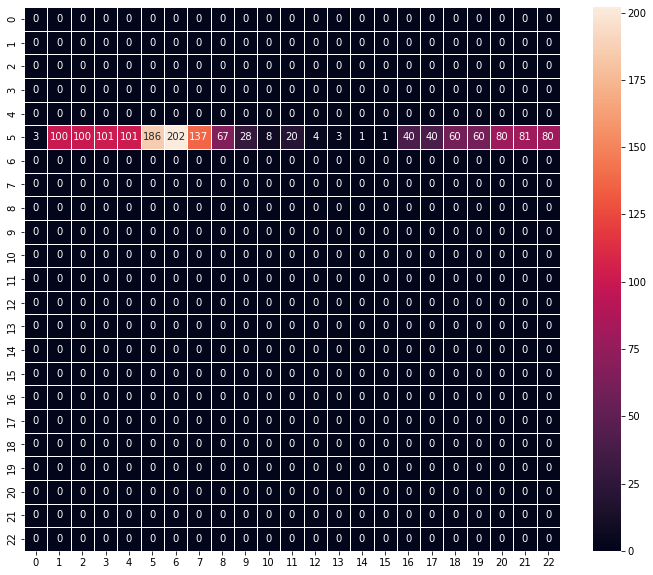

In [176]:
plt.figure(figsize = (12,10))
cfm_plot_3 = sn.heatmap(df_cfm_3, annot=True, linewidths=.5, fmt='n')#, xticklabels=names_as_ints, yticklabels=names_as_ints)

---------
---------
---------
---------
---------
---------


In [59]:
# Build the VGG16 model
vgg16_model = ResNet50(weights='imagenet', include_top=False, classes=23, input_shape=input_shape)

In [60]:
# Freeze the layers in the VGG16 model
for layer in vgg16_model.layers:
    layer.trainable = False

In [61]:
# Define image dimensions
img_height = 224
img_width = 224
input_shape = (img_height, img_width, 3)

# Set the seed validation
seed_train_validation = 2 # Must be same for train_ds and val_ds
shuffle_value = True # Must be same

# Number of classes
num_classes_2 = 23 

# Set the path for the dataset
train_data_dir_3 = '/Users/jonathanforsyth/Documents/UMass/Machine_Learning/spectra/images/train4/'
val_data_dir_3 = '/Users/jonathanforsyth/Documents/UMass/Machine_Learning/spectra/images/validation4/'

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     #validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) #

In [62]:
class_subset = sorted(os.listdir('/Users/jonathanforsyth/Documents/UMass/Machine_Learning/spectra/images/train1/'))

# Training Dataset
#train_ds_3 = keras.utils.image_dataset_from_directory(directory=train_data_dir_3,
#                                                    labels='inferred',
#                                                    label_mode='int',
#                                                    batch_size=45,
#                                                    image_size=(img_height, img_width),
#                                                    #shuffle=shuffle_value, 
#                                                    seed = seed_train_validation)

#train_ds_3 = train_generator.flow_from_directory(directory=train_data_dir_2,
#                                               target_size=(224, 224),
#                                               class_mode='categorical',
#                                               classes=class_subset,
#                                               #subset='training',
#                                               batch_size=45, 
#                                               #shuffle=True,
#                                               seed=42)

# Training Dataset
train_ds_3 = train_generator.flow_from_directory(directory=train_data_dir_2,
                                               target_size=(224, 224),
                                               class_mode='sparse',
                                               classes=class_subset,
                                               #subset='training',
                                               batch_size=45, 
                                               #shuffle=True,
                                               seed=42)

# Validation Dataset
val_ds_3 = train_generator.flow_from_directory(directory=val_data_dir_2,
                                               target_size=(224, 224),
                                               class_mode='sparse',
                                               classes=class_subset,
                                               #subset='training',
                                               batch_size=45, 
                                               #shuffle=True,
                                               seed=42)



Found 1503 images belonging to 23 classes.
Found 794 images belonging to 23 classes.


In [63]:
# Build the final classification layers
model_4 = tf.keras.models.Sequential([
    vgg16_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes_2, activation='relu')
])

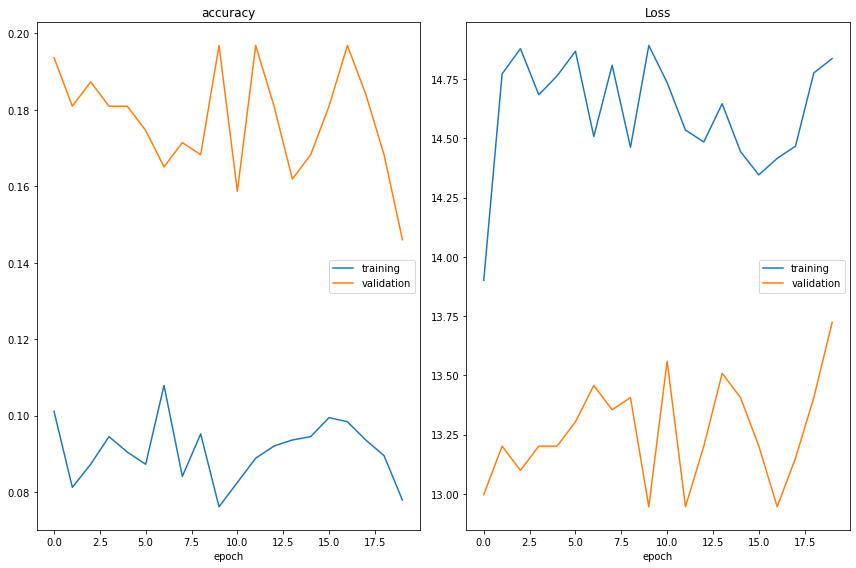

accuracy
	training         	 (min:    0.076, max:    0.108, cur:    0.078)
	validation       	 (min:    0.146, max:    0.197, cur:    0.146)
Loss
	training         	 (min:   13.901, max:   14.892, cur:   14.836)
	validation       	 (min:   12.946, max:   13.724, cur:   13.724)


In [64]:
BATCH_SIZE=101
steps_per_epoch = train_ds_3.samples // BATCH_SIZE
val_steps = val_ds_3.samples // BATCH_SIZE
n_epochs = 60
optimizer=tf.keras.optimizers.Adam(learning_rate=.01)

# Compile the model
model_4.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)


# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')


# Train the model and store the history
#history_4 = model_4.fit(train_ds_3,
#                        epochs=n_epochs,
#                        #validation_data=val_ds_2, 
#                        callbacks=[cp_callback])

# Actual fitting of the model
history_4 = model_4.fit(train_ds_3,
                    epochs=n_epochs, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_ds_3,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    verbose=False)


In [71]:
len(train_ds_3[1])

2

In [79]:
model_4.load_weights('img_model.weights.best.hdf5')

In [78]:
predictions_4 = np.array([])
labels_4 =  np.array([])
for x, y in train_ds_3:
  predictions_4 = np.concatenate([predictions_4, np.argmax(model_4.predict(x), axis = -1)])
  labels_4 = np.concatenate([labels_4, y])

2/2 [==============================] - 5s 1s/step


KeyboardInterrupt: 

In [ ]:
cm4=tf.math.confusion_matrix(labels=labels_4, predictions=predictions_4).numpy()

---------
---------
---------
---------
---------
---------


In [ ]:
# Define image dimensions
img_height = 224
img_width = 224
input_shape = (img_height, img_width, 3)

# Set the seed validation
seed_train_validation = 2 # Must be same for train_ds and val_ds
shuffle_value = True # Must be same

# Number of classes
num_classes = 10 

# Set the path for the dataset
train_data_dir = '/Users/jonathanforsyth/Documents/UMass/Machine_Learning/spectra/images/train4/'
val_data_dir = '/Users/jonathanforsyth/Documents/UMass/Machine_Learning/spectra/images/validation4/'

In [ ]:
class_subset = sorted(os.listdir('/Users/jonathanforsyth/Documents/UMass/Machine_Learning/spectra/images/train4/'))
class_subset = [int(x) for x in class_subset]
class_subset.sort()
class_subset

[14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

In [100]:
# Training Dataset
train_ds = keras.utils.image_dataset_from_directory(directory=train_data_dir,
                                                    labels='inferred',
                                                    label_mode='categorical',
                                                    batch_size=101,
                                                    image_size=(img_height, img_width),
                                                    shuffle=shuffle_value, 
                                                    seed = seed_train_validation)

# Validation Dataset
val_ds = keras.utils.image_dataset_from_directory(directory=val_data_dir,
                                                    labels='inferred',
                                                    label_mode='categorical',
                                                    batch_size=53,
                                                    image_size=(img_height, img_width),
                                                    shuffle=shuffle_value, 
                                                    seed = seed_train_validation)

Found 637 files belonging to 10 classes.
Found 532 files belonging to 10 classes.


In [102]:
# Build the VGG16 model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape, classes=10)

In [103]:
# Freeze the layers in the VGG16 model
for layer in vgg16_model.layers:
    layer.trainable = False

In [104]:
# Build the final classification layers
model = tf.keras.models.Sequential([
    vgg16_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [105]:
# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [106]:
# Train the model and store the history
history = model.fit(train_ds,
                    epochs=5,
                    validation_data=val_ds)

Epoch 1/5
7/7 [==============================] - 247s 38s/step - loss: 34.9496 - accuracy: 0.2386 - val_loss: 11.4123 - val_accuracy: 0.3327
Epoch 2/5
7/7 [==============================] - 266s 40s/step - loss: 26.2329 - accuracy: 0.2700 - val_loss: 4.4376 - val_accuracy: 0.3383
Epoch 3/5
7/7 [==============================] - 285s 43s/step - loss: 14.3242 - accuracy: 0.2559 - val_loss: 4.4128 - val_accuracy: 0.2707
Epoch 4/5
7/7 [==============================] - 282s 42s/step - loss: 7.6440 - accuracy: 0.2826 - val_loss: 2.2049 - val_accuracy: 0.3872
Epoch 5/5
7/7 [==============================] - 257s 39s/step - loss: 3.9802 - accuracy: 0.2763 - val_loss: 1.7474 - val_accuracy: 0.3853


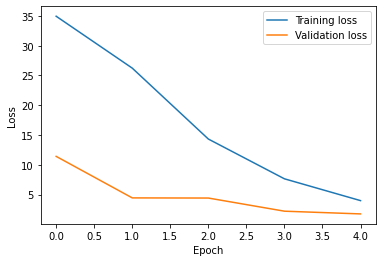

In [107]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

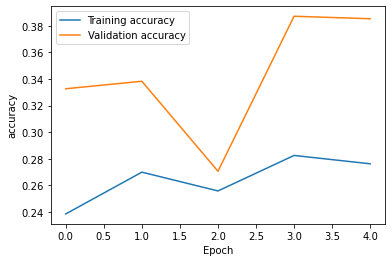

In [108]:
# Plot the training and validation loss over epochs
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [110]:
predictions = np.array([])
labels =  np.array([])
for x, y in train_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

1/1 [==============================] - 9s 9s/step


In [111]:
cm=tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

In [112]:
cm[0]

array([112,  33,  32,   9,   0,   0,   0,   0,   0,   0], dtype=int32)

In [113]:
df_cfm = pd.DataFrame(cm)
df_cfm=df_cfm.transpose()
df_cfm

,0,1,2,3,4,5,6,7,8,9
0,112,63,37,15,11,2,4,1,0,1
1,33,92,35,19,5,3,0,1,0,0
2,32,37,55,18,7,1,0,1,0,0
3,9,9,9,15,3,1,0,0,0,0
4,0,0,0,0,2,0,0,0,0,0
5,0,0,1,0,0,1,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,1,0
9,0,0,0,0,0,0,0,0,0,0


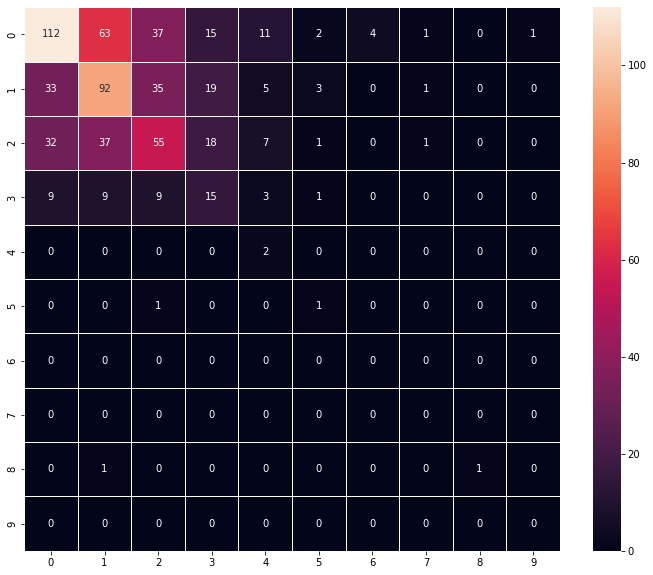

In [115]:
plt.figure(figsize = (12,10))
cfm_plot = sn.heatmap(df_cfm, annot=True, linewidths=.5, fmt='n')#, xticklabels=names_as_ints, yticklabels=names_as_ints)

In [86]:
class_subset = sorted(os.listdir('/Users/jonathanforsyth/Documents/UMass/Machine_Learning/spectra/images/train4/'))
class_subset = [int(x) for x in class_subset]
class_subset.sort()
class_subset

[14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

---------
---------
---------
---------
---------
---------


In [127]:
# Define image dimensions
img_height = 224
img_width = 224
input_shape = (img_height, img_width, 3)

# Set the seed validation
seed_train_validation = 2 # Must be same for train_ds and val_ds
shuffle_value = True # Must be same

# Number of classes
num_classes = 23 

# Set the path for the dataset
train_data_dir = '/Users/jonathanforsyth/Documents/UMass/Machine_Learning/spectra/images/train5/'
val_data_dir = '/Users/jonathanforsyth/Documents/UMass/Machine_Learning/spectra/images/validation5/'

In [128]:
# Training Dataset
train_ds = keras.utils.image_dataset_from_directory(directory=train_data_dir,
                                                    labels='inferred',
                                                    label_mode='categorical',
                                                    batch_size=65,
                                                    image_size=(img_height, img_width),
                                                    shuffle=shuffle_value, 
                                                    seed = seed_train_validation)

# Validation Dataset
val_ds = keras.utils.image_dataset_from_directory(directory=val_data_dir,
                                                    labels='inferred',
                                                    label_mode='categorical',
                                                    batch_size=65,
                                                    image_size=(img_height, img_width),
                                                    shuffle=shuffle_value, 
                                                    seed = seed_train_validation)

Found 65 files belonging to 23 classes.
Found 65 files belonging to 23 classes.


In [130]:
# Build the VGG16 model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape, classes=num_classes)

In [131]:
# Freeze the layers in the VGG16 model
for layer in vgg16_model.layers:
    layer.trainable = False

In [132]:
# Build the final classification layers
model = tf.keras.models.Sequential([
    vgg16_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [133]:
# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [134]:
# Train the model and store the history
history = model.fit(train_ds,
                    epochs=5,
                    validation_data=val_ds)

Epoch 1/5
1/1 [==============================] - 24s 24s/step - loss: 25.5282 - accuracy: 0.0615 - val_loss: 24.4465 - val_accuracy: 0.0615
Epoch 2/5
1/1 [==============================] - 27s 27s/step - loss: 39.1776 - accuracy: 0.0615 - val_loss: 21.8043 - val_accuracy: 0.0308
Epoch 3/5
1/1 [==============================] - 27s 27s/step - loss: 37.3928 - accuracy: 0.0308 - val_loss: 22.5218 - val_accuracy: 0.0308
Epoch 4/5
1/1 [==============================] - 27s 27s/step - loss: 35.2620 - accuracy: 0.0769 - val_loss: 19.7884 - val_accuracy: 0.0308
Epoch 5/5
1/1 [==============================] - 29s 29s/step - loss: 27.5653 - accuracy: 0.0923 - val_loss: 18.0064 - val_accuracy: 0.0308


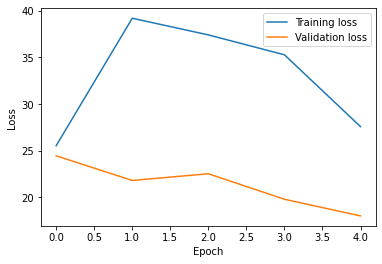

In [135]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

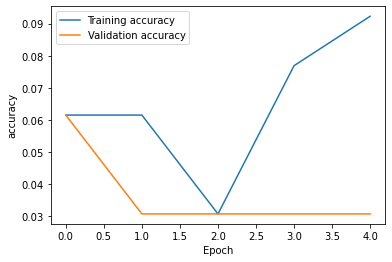

In [136]:
# Plot the training and validation loss over epochs
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [137]:
predictions = np.array([])
labels =  np.array([])
for x, y in train_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

3/3 [==============================] - 15s 4s/step


In [138]:
cm=tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

In [139]:
cm[0]

array([1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int32)

In [140]:
df_cfm = pd.DataFrame(cm)
df_cfm=df_cfm.transpose()
df_cfm

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,2,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,1,0,3,1,...,0,0,0,1,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


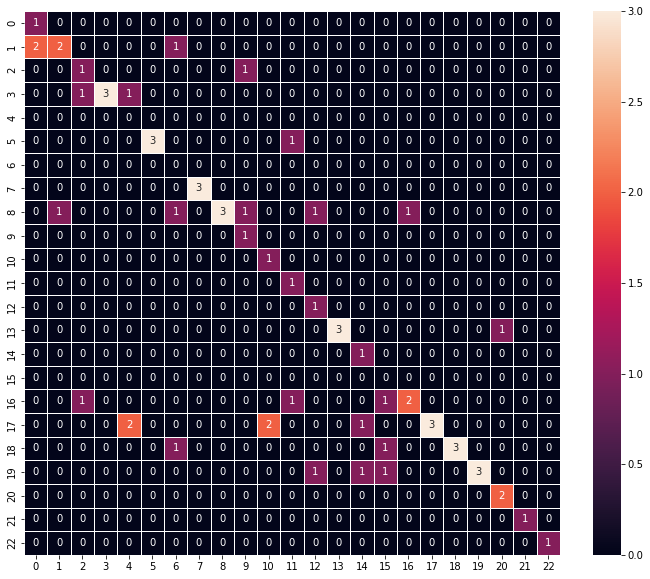

In [141]:
plt.figure(figsize = (12,10))
cfm_plot = sn.heatmap(df_cfm, annot=True, linewidths=.5, fmt='n')#, xticklabels=names_as_ints, yticklabels=names_as_ints)

---------
---------
---------
---------
---------
---------


In [202]:
# Define image dimensions
img_height = 224
img_width = 224
input_shape = (img_height, img_width, 3)

# Set the seed validation
seed_train_validation = 2 # Must be same for train_ds and val_ds
shuffle_value = True # Must be same

# Number of classes
num_classes = 23 

# Set the path for the dataset
train_data_dir = '/Users/jonathanforsyth/Documents/UMass/Machine_Learning/spectra/images/train6/'
val_data_dir = '/Users/jonathanforsyth/Documents/UMass/Machine_Learning/spectra/images/validation6/'

In [203]:
# Training Dataset
train_ds = keras.utils.image_dataset_from_directory(directory=train_data_dir,
                                                    labels='inferred',
                                                    label_mode='categorical',
                                                    batch_size=101,
                                                    image_size=(img_height, img_width),
                                                    shuffle=shuffle_value, 
                                                    seed = seed_train_validation)

# Validation Dataset
val_ds = keras.utils.image_dataset_from_directory(directory=val_data_dir,
                                                    labels='inferred',
                                                    label_mode='categorical',
                                                    batch_size=53,
                                                    image_size=(img_height, img_width),
                                                    shuffle=shuffle_value, 
                                                    seed = seed_train_validation)

Found 1503 files belonging to 23 classes.
Found 794 files belonging to 23 classes.


In [204]:
# Build the VGG16 model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape, classes=num_classes)

In [205]:
# Freeze the layers in the VGG16 model
for layer in vgg16_model.layers:
    layer.trainable = False

In [206]:
# Build the final classification layers
model = tf.keras.models.Sequential([
    vgg16_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [207]:
checkpoint_path = "spectra/images/checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [167]:
# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'],)

In [168]:
# Train the model and store the history
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds,
                    callbacks=[cp_callback])

Epoch 1/10
15/15 [==============================] - ETA: 0s - loss: 22.3706 - accuracy: 0.0938 
Epoch 1: saving model to spectra/images/cp.ckpt
15/15 [==============================] - 515s 35s/step - loss: 22.3706 - accuracy: 0.0938 - val_loss: 3.6224 - val_accuracy: 0.1965
Epoch 2/10
15/15 [==============================] - ETA: 0s - loss: 4.3650 - accuracy: 0.0958 
Epoch 2: saving model to spectra/images/cp.ckpt
15/15 [==============================] - 468s 32s/step - loss: 4.3650 - accuracy: 0.0958 - val_loss: 2.9907 - val_accuracy: 0.1826
Epoch 3/10
15/15 [==============================] - ETA: 0s - loss: 3.1565 - accuracy: 0.0905 
Epoch 3: saving model to spectra/images/cp.ckpt
15/15 [==============================] - 466s 32s/step - loss: 3.1565 - accuracy: 0.0905 - val_loss: 2.9960 - val_accuracy: 0.2531
Epoch 4/10
15/15 [==============================] - ETA: 0s - loss: 3.0895 - accuracy: 0.1244 
Epoch 4: saving model to spectra/images/cp.ckpt
15/15 [==========================

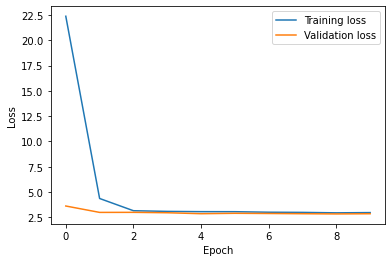

In [169]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

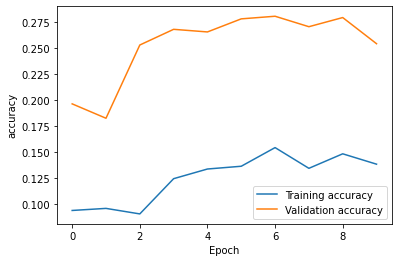

In [170]:
# Plot the training and validation loss over epochs
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [171]:
predictions = np.array([])
labels =  np.array([])
for x, y in train_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

3/3 [==============================] - 19s 6s/step


In [172]:
cm=tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

In [173]:
cm[0]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int32)

In [174]:
df_cfm = pd.DataFrame(cm)
df_cfm=df_cfm.transpose()
df_cfm

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,10,27,2,4,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


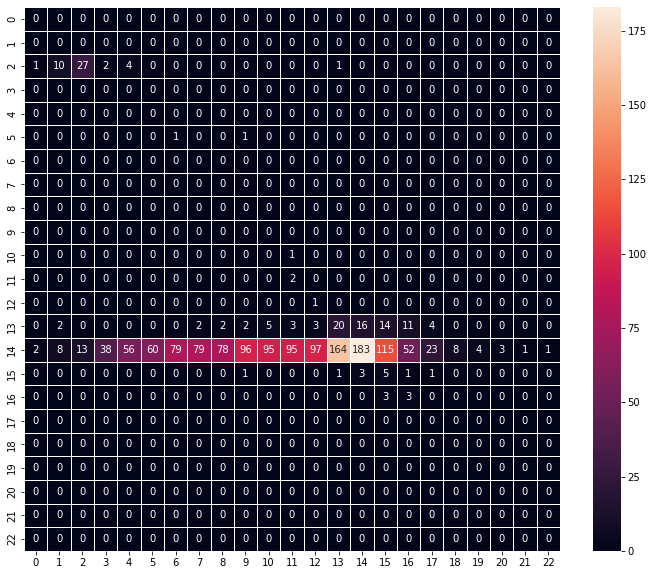

In [175]:
plt.figure(figsize = (12,10))
cfm_plot = sn.heatmap(df_cfm, annot=True, linewidths=.5, fmt='n')#, xticklabels=names_as_ints, yticklabels=names_as_ints)

---------
---------
---------
---------
---------
---------


In [196]:
checkpoint_path = "spectra/images/checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [209]:
# Build the final classification layers
model = tf.keras.models.Sequential([
    vgg16_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [210]:
model.load_weights(checkpoint_path)

In [211]:
# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [213]:
# Train the model and store the history
history2 = model.fit(train_ds,
                    epochs=5,
                    validation_data=val_ds,
                    callbacks=[cp_callback])

Epoch 1/5
15/15 [==============================] - ETA: 0s - loss: 2.9235 - accuracy: 0.1271 
Epoch 1: saving model to spectra/images/checkpoints/cp.ckpt
15/15 [==============================] - 469s 32s/step - loss: 2.9235 - accuracy: 0.1271 - val_loss: 2.8117 - val_accuracy: 0.2632
Epoch 2/5
15/15 [==============================] - ETA: 0s - loss: 2.8905 - accuracy: 0.1344 
Epoch 2: saving model to spectra/images/checkpoints/cp.ckpt
15/15 [==============================] - 483s 32s/step - loss: 2.8905 - accuracy: 0.1344 - val_loss: 2.7997 - val_accuracy: 0.2771
Epoch 3/5
15/15 [==============================] - ETA: 0s - loss: 2.8720 - accuracy: 0.1504 
Epoch 3: saving model to spectra/images/checkpoints/cp.ckpt
15/15 [==============================] - 466s 32s/step - loss: 2.8720 - accuracy: 0.1504 - val_loss: 2.7732 - val_accuracy: 0.2771
Epoch 4/5
15/15 [==============================] - ETA: 0s - loss: 2.8287 - accuracy: 0.1411 
Epoch 4: saving model to spectra/images/checkpoints

---------
---------
---------
---------
---------
---------


In [196]:
checkpoint_path = "spectra/images/checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [214]:
# Build the final classification layers
model = tf.keras.models.Sequential([
    vgg16_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [215]:
model.load_weights(checkpoint_path)

In [216]:
# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [217]:
# Train the model and store the history
history3 = model.fit(train_ds,
                    epochs=5,
                    validation_data=val_ds,
                    callbacks=[cp_callback])

Epoch 1/5
15/15 [==============================] - ETA: 0s - loss: 2.8175 - accuracy: 0.1464 
Epoch 1: saving model to spectra/images/checkpoints/cp.ckpt
15/15 [==============================] - 508s 35s/step - loss: 2.8175 - accuracy: 0.1464 - val_loss: 2.7238 - val_accuracy: 0.2657
Epoch 2/5
15/15 [==============================] - ETA: 0s - loss: 2.8166 - accuracy: 0.1377 
Epoch 2: saving model to spectra/images/checkpoints/cp.ckpt
15/15 [==============================] - 484s 33s/step - loss: 2.8166 - accuracy: 0.1377 - val_loss: 2.6886 - val_accuracy: 0.2720
Epoch 3/5
15/15 [==============================] - ETA: 0s - loss: 2.8110 - accuracy: 0.1331 
Epoch 3: saving model to spectra/images/checkpoints/cp.ckpt
15/15 [==============================] - 478s 32s/step - loss: 2.8110 - accuracy: 0.1331 - val_loss: 2.7005 - val_accuracy: 0.2620
Epoch 4/5
15/15 [==============================] - ETA: 0s - loss: 2.7975 - accuracy: 0.1444 
Epoch 4: saving model to spectra/images/checkpoints

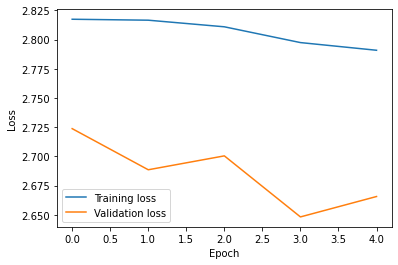

In [218]:
# Plot the training and validation loss over epochs
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

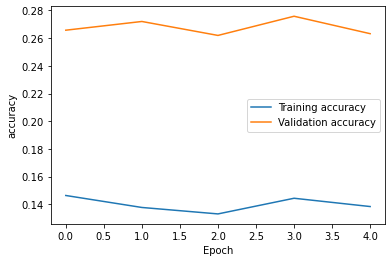

In [219]:
# Plot the training and validation loss over epochs
plt.plot(history3.history['accuracy'], label='Training accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [220]:
predictions = np.array([])
labels =  np.array([])
for x, y in train_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

3/3 [==============================] - 18s 6s/step


In [221]:
cm=tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

In [222]:
cm[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int32)

In [223]:
df_cfm = pd.DataFrame(cm)
df_cfm=df_cfm.transpose()
df_cfm

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,13,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


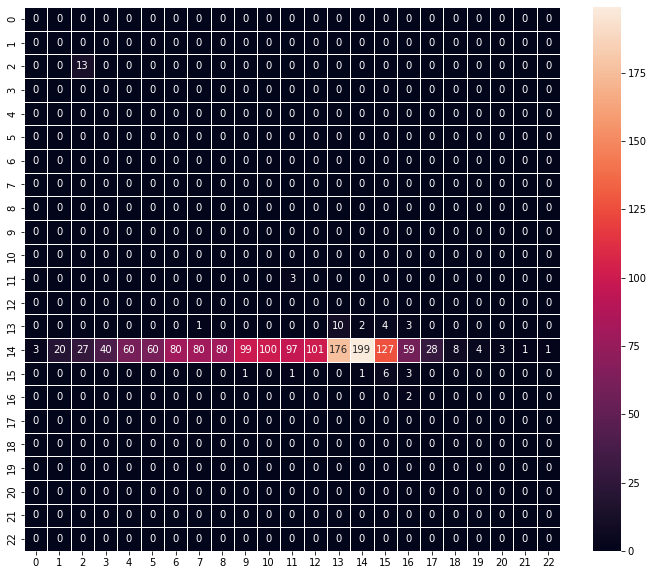

In [224]:
plt.figure(figsize = (12,10))
cfm_plot = sn.heatmap(df_cfm, annot=True, linewidths=.5, fmt='n')#, xticklabels=names_as_ints, yticklabels=names_as_ints)

In [227]:
cm[14]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         2, 199,   1,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

---------
---------
---------
---------
---------
---------


In [278]:
# Define image dimensions
img_height = 224
img_width = 224
input_shape = (img_height, img_width, 3)

# Set the seed validation
seed_train_validation = 2 # Must be same for train_ds and val_ds
shuffle_value = True # Must be same

# Number of classes
num_classes = 8 

# Set the path for the dataset
train_data_dir = '/Users/jonathanforsyth/Documents/UMass/Machine_Learning/spectra/images/train7/'
val_data_dir = '/Users/jonathanforsyth/Documents/UMass/Machine_Learning/spectra/images/validation7/'

In [279]:
# Training Dataset
train_ds = keras.utils.image_dataset_from_directory(directory=train_data_dir,
                                                    labels='inferred',
                                                    label_mode='int',
                                                    batch_size=23,
                                                    image_size=(img_height, img_width),
                                                    shuffle=shuffle_value, 
                                                    seed = seed_train_validation)

# Validation Dataset
val_ds = keras.utils.image_dataset_from_directory(directory=val_data_dir,
                                                    labels='inferred',
                                                    label_mode='int',
                                                    batch_size=8,
                                                    image_size=(img_height, img_width),
                                                    shuffle=shuffle_value, 
                                                    seed = seed_train_validation)

Found 226 files belonging to 8 classes.
Found 84 files belonging to 8 classes.


In [280]:
# Build the VGG16 model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape, classes=num_classes)

In [281]:
# Freeze the layers in the VGG16 model
for layer in vgg16_model.layers:
    layer.trainable = False

In [282]:
# Build the final classification layers
model = tf.keras.models.Sequential([
    vgg16_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [283]:
checkpoint_path = "spectra/images/checkpoints/cp1.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [284]:
# Compile the model
model.compile(optimizer='SGD', 
              loss='mean_absolute_error', 
              metrics=['accuracy'],)

In [285]:
# Train the model and store the history
history4 = model.fit(train_ds,
                    epochs=5,
                    validation_data=val_ds,
                    callbacks=[cp_callback])

Epoch 1/5
10/10 [==============================] - ETA: 0s - loss: 3.3883 - accuracy: 0.1150
Epoch 1: saving model to spectra/images/checkpoints/cp1.ckpt
10/10 [==============================] - 59s 6s/step - loss: 3.3883 - accuracy: 0.1150 - val_loss: 4.2321 - val_accuracy: 0.1071
Epoch 2/5
10/10 [==============================] - ETA: 0s - loss: 3.3883 - accuracy: 0.1106
Epoch 2: saving model to spectra/images/checkpoints/cp1.ckpt
10/10 [==============================] - 68s 7s/step - loss: 3.3883 - accuracy: 0.1106 - val_loss: 4.2321 - val_accuracy: 0.1071
Epoch 3/5
10/10 [==============================] - ETA: 0s - loss: 3.3883 - accuracy: 0.1372
Epoch 3: saving model to spectra/images/checkpoints/cp1.ckpt
10/10 [==============================] - 71s 7s/step - loss: 3.3883 - accuracy: 0.1372 - val_loss: 4.2321 - val_accuracy: 0.1071
Epoch 4/5
10/10 [==============================] - ETA: 0s - loss: 3.3883 - accuracy: 0.1062
Epoch 4: saving model to spectra/images/checkpoints/cp1.ck

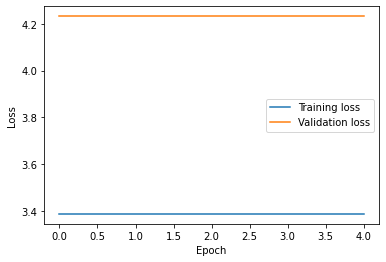

In [295]:
# Plot the training and validation loss over epochs
plt.plot(history4.history['loss'], label='Training loss')
plt.plot(history4.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

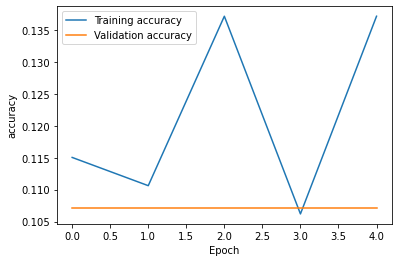

In [296]:
# Plot the training and validation loss over epochs
plt.plot(history4.history['accuracy'], label='Training accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

---------
---------
---------
---------
---------
---------


In [291]:
checkpoint_path = "spectra/images/checkpoints/cp1.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [292]:
# Build the final classification layers
model = tf.keras.models.Sequential([
    vgg16_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [293]:
model.load_weights(checkpoint_path)

In [294]:
# Compile the model
model.compile(optimizer='SGD', 
              loss='mean_absolute_error',  
              metrics=['accuracy'])

In [297]:
# Train the model and store the history
history5 = model.fit(train_ds,
                    epochs=5,
                    validation_data=val_ds,
                    callbacks=[cp_callback])

Epoch 1/5
10/10 [==============================] - ETA: 0s - loss: 3.3883 - accuracy: 0.1327
Epoch 1: saving model to spectra/images/checkpoints/cp1.ckpt
10/10 [==============================] - 62s 6s/step - loss: 3.3883 - accuracy: 0.1327 - val_loss: 4.2321 - val_accuracy: 0.1071
Epoch 2/5
10/10 [==============================] - ETA: 0s - loss: 3.3883 - accuracy: 0.1062
Epoch 2: saving model to spectra/images/checkpoints/cp1.ckpt
10/10 [==============================] - 71s 7s/step - loss: 3.3883 - accuracy: 0.1062 - val_loss: 4.2321 - val_accuracy: 0.1071
Epoch 3/5
10/10 [==============================] - ETA: 0s - loss: 3.3883 - accuracy: 0.1150
Epoch 3: saving model to spectra/images/checkpoints/cp1.ckpt
10/10 [==============================] - 77s 8s/step - loss: 3.3883 - accuracy: 0.1150 - val_loss: 4.2321 - val_accuracy: 0.1071
Epoch 4/5
10/10 [==============================] - ETA: 0s - loss: 3.3883 - accuracy: 0.1327
Epoch 4: saving model to spectra/images/checkpoints/cp1.ck

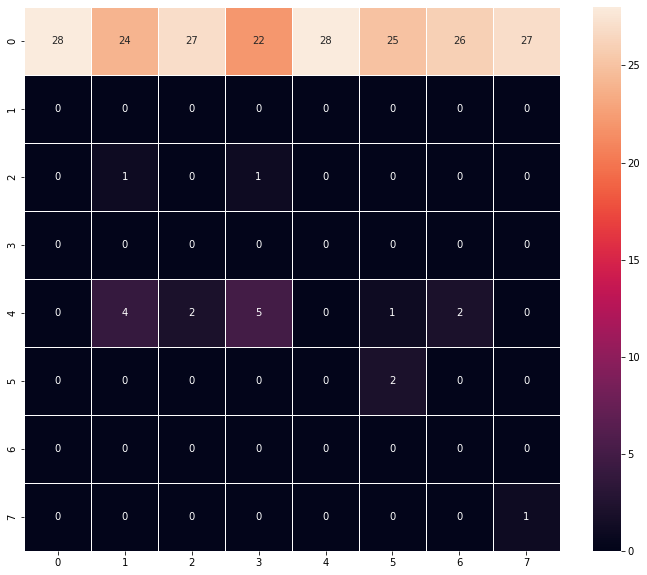

In [304]:
plt.figure(figsize = (12,10))
cfm_plot = sn.heatmap(df_cfm, annot=True, linewidths=.5, fmt='n')#, xticklabels=names_as_ints, yticklabels=names_as_ints)

---------
---------
---------
---------
---------
---------


---------
---------
---------
---------
---------
---------


In [306]:
# Build the final classification layers
model = tf.keras.models.Sequential([
    vgg16_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [307]:
model.load_weights(checkpoint_path)

In [308]:
# Compile the model
model.compile(optimizer='SGD', 
              loss='mean_absolute_error',  
              metrics=['accuracy'])

In [309]:
# Train the model and store the history
history5 = model.fit(train_ds,
                    epochs=5,
                    validation_data=val_ds,
                    callbacks=[cp_callback])

Epoch 1/5
10/10 [==============================] - ETA: 0s - loss: 3.3883 - accuracy: 0.1150
Epoch 1: saving model to spectra/images/checkpoints/cp1.ckpt
10/10 [==============================] - 63s 6s/step - loss: 3.3883 - accuracy: 0.1150 - val_loss: 4.2321 - val_accuracy: 0.1071
Epoch 2/5
10/10 [==============================] - ETA: 0s - loss: 3.3883 - accuracy: 0.1018
Epoch 2: saving model to spectra/images/checkpoints/cp1.ckpt
10/10 [==============================] - 75s 8s/step - loss: 3.3883 - accuracy: 0.1018 - val_loss: 4.2321 - val_accuracy: 0.1071
Epoch 3/5
10/10 [==============================] - ETA: 0s - loss: 3.3883 - accuracy: 0.1283
Epoch 3: saving model to spectra/images/checkpoints/cp1.ckpt
10/10 [==============================] - 74s 8s/step - loss: 3.3883 - accuracy: 0.1283 - val_loss: 4.2321 - val_accuracy: 0.1071
Epoch 4/5
10/10 [==============================] - ETA: 0s - loss: 3.3883 - accuracy: 0.1239
Epoch 4: saving model to spectra/images/checkpoints/cp1.ck

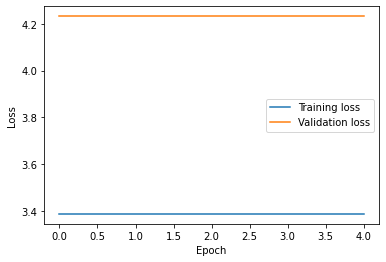

In [310]:
# Plot the training and validation loss over epochs
plt.plot(history5.history['loss'], label='Training loss')
plt.plot(history5.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

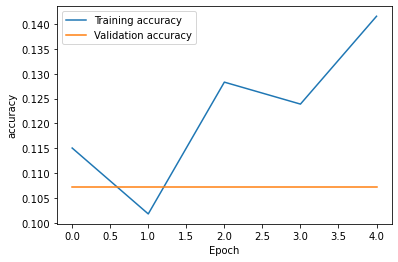

In [311]:
# Plot the training and validation loss over epochs
plt.plot(history5.history['accuracy'], label='Training accuracy')
plt.plot(history5.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [312]:
predictions = np.array([])
labels =  np.array([])
for x, y in train_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, y])

1/1 [==============================] - 4s 4s/step


In [313]:
cm=tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

In [314]:
cm[0]

array([28,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [315]:
df_cfm = pd.DataFrame(cm)
df_cfm=df_cfm.transpose()
df_cfm

,0,1,2,3,4,5,6,7
0,28,24,27,22,28,25,26,27
1,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,4,2,5,0,1,2,0
5,0,0,0,0,0,2,0,0
6,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1


---------
---------
---------
---------
---------
---------


In [320]:
# Define image dimensions
img_height = 224
img_width = 224
input_shape = (img_height, img_width, 3)

# Set the seed validation
seed_train_validation = 2 # Must be same for train_ds and val_ds
shuffle_value = True # Must be same

# Number of classes
num_classes = 2 

# Set the path for the dataset
train_data_dir = '/Users/jonathanforsyth/Documents/UMass/Machine_Learning/spectra/images/train8/'
val_data_dir = '/Users/jonathanforsyth/Documents/UMass/Machine_Learning/spectra/images/validation8/'

In [324]:
# Training Dataset
train_ds = keras.utils.image_dataset_from_directory(directory=train_data_dir,
                                                    labels='inferred',
                                                    label_mode='categorical',
                                                    batch_size=20,
                                                    image_size=(img_height, img_width),
                                                    shuffle=shuffle_value, 
                                                    seed = seed_train_validation)

# Validation Dataset
val_ds = keras.utils.image_dataset_from_directory(directory=val_data_dir,
                                                    labels='inferred',
                                                    label_mode='categorical',
                                                    batch_size=9,
                                                    image_size=(img_height, img_width),
                                                    shuffle=shuffle_value, 
                                                    seed = seed_train_validation)

Found 224 files belonging to 2 classes.
Found 84 files belonging to 2 classes.


In [358]:
checkpoint_path = "spectra/images/checkpoints/cp1.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [326]:
# Build the final classification layers
model = tf.keras.models.Sequential([
    vgg16_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [327]:
# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [328]:
# Train the model and store the history
history3 = model.fit(train_ds,
                    epochs=20,
                    validation_data=val_ds,
                    callbacks=[cp_callback])

Epoch 1/20
12/12 [==============================] - ETA: 0s - loss: 15.1090 - accuracy: 0.5580
Epoch 1: saving model to spectra/images/checkpoints/cp1.ckpt
12/12 [==============================] - 58s 5s/step - loss: 15.1090 - accuracy: 0.5580 - val_loss: 4.2962 - val_accuracy: 0.7024
Epoch 2/20
12/12 [==============================] - ETA: 0s - loss: 11.7805 - accuracy: 0.6830
Epoch 2: saving model to spectra/images/checkpoints/cp1.ckpt
12/12 [==============================] - 68s 6s/step - loss: 11.7805 - accuracy: 0.6830 - val_loss: 2.7198 - val_accuracy: 0.7381
Epoch 3/20
12/12 [==============================] - ETA: 0s - loss: 8.9316 - accuracy: 0.6786
Epoch 3: saving model to spectra/images/checkpoints/cp1.ckpt
12/12 [==============================] - 71s 6s/step - loss: 8.9316 - accuracy: 0.6786 - val_loss: 3.4083 - val_accuracy: 0.6667
Epoch 4/20
12/12 [==============================] - ETA: 0s - loss: 8.5303 - accuracy: 0.6652
Epoch 4: saving model to spectra/images/checkpoint

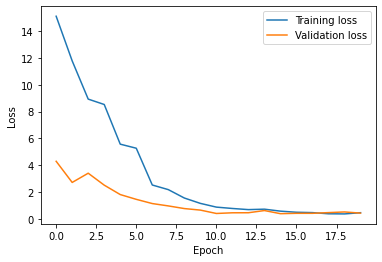

In [330]:
# Plot the training and validation loss over epochs
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

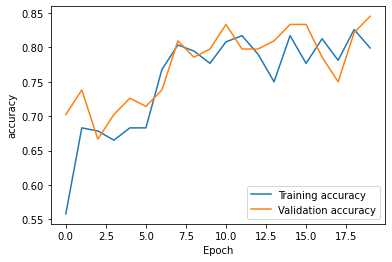

In [331]:
# Plot the training and validation loss over epochs
plt.plot(history3.history['accuracy'], label='Training accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [332]:
predictions = np.array([])
labels =  np.array([])
for x, y in train_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

1/1 [==============================] - 1s 1s/step


In [333]:
cm=tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

In [334]:
cm[0]

array([110,   2], dtype=int32)

In [335]:
df_cfm = pd.DataFrame(cm)
df_cfm=df_cfm.transpose()
df_cfm

,0,1
0,110,12
1,2,100


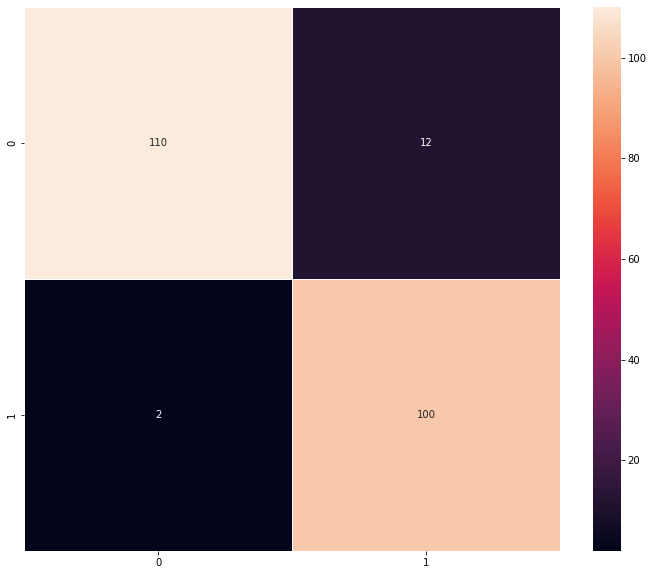

In [336]:
plt.figure(figsize = (12,10))
cfm_plot = sn.heatmap(df_cfm, annot=True, linewidths=.5, fmt='n')#, xticklabels=names_as_ints, yticklabels=names_as_ints)

In [337]:
predictions = np.array([])
labels =  np.array([])
for x, y in val_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

1/1 [==============================] - 1s 541ms/step


In [338]:
cm=tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

In [339]:
cm[0]

array([24,  8], dtype=int32)

In [340]:
df_cfm = pd.DataFrame(cm)
df_cfm=df_cfm.transpose()
df_cfm

,0,1
0,24,5
1,8,47


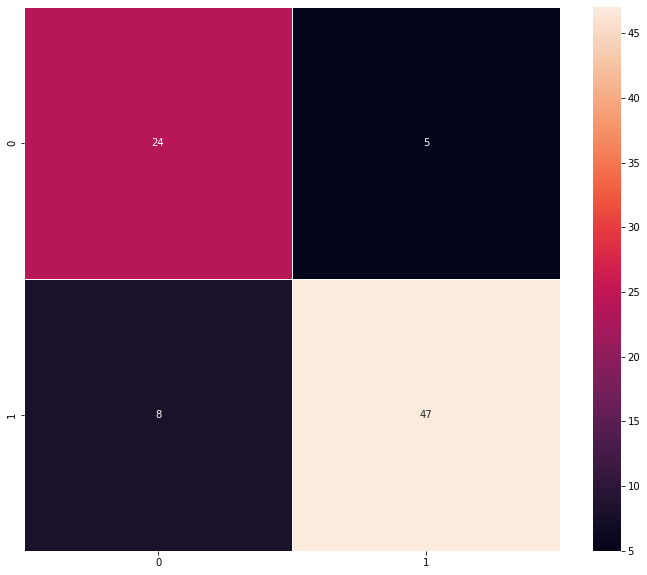

In [341]:
plt.figure(figsize = (12,10))
cfm_plot = sn.heatmap(df_cfm, annot=True, linewidths=.5, fmt='n')#, xticklabels=names_as_ints, yticklabels=names_as_ints)

---------
---------
---------
---------
---------
---------


In [359]:
# Define image dimensions
img_height = 224
img_width = 224
input_shape = (img_height, img_width, 3)

# Set the seed validation
seed_train_validation = 2 # Must be same for train_ds and val_ds
shuffle_value = True # Must be same

# Number of classes
num_classes = 2 

# Set the path for the dataset
train_data_dir = '/Users/jonathanforsyth/Documents/UMass/Machine_Learning/spectra/images/train9/'
val_data_dir = '/Users/jonathanforsyth/Documents/UMass/Machine_Learning/spectra/images/validation9/'

In [360]:
# Training Dataset
train_ds = keras.utils.image_dataset_from_directory(directory=train_data_dir,
                                                    labels='inferred',
                                                    label_mode='categorical',
                                                    batch_size=94,
                                                    image_size=(img_height, img_width),
                                                    shuffle=shuffle_value, 
                                                    seed = seed_train_validation)

# Validation Dataset
val_ds = keras.utils.image_dataset_from_directory(directory=val_data_dir,
                                                    labels='inferred',
                                                    label_mode='categorical',
                                                    batch_size=31,
                                                    image_size=(img_height, img_width),
                                                    shuffle=shuffle_value, 
                                                    seed = seed_train_validation)

Found 937 files belonging to 2 classes.
Found 306 files belonging to 2 classes.


In [361]:
# Build the final classification layers
model = tf.keras.models.Sequential([
    vgg16_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

In [362]:
model.load_weights(checkpoint_path)

In [363]:
# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [364]:
checkpoint_path = "spectra/images/checkpoints/cp2.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [365]:
# Train the model and store the history
history4 = model.fit(train_ds,
                    epochs=15,
                    validation_data=val_ds,
                    callbacks=[cp_callback])

Epoch 1/15
10/10 [==============================] - ETA: 0s - loss: 1.0416 - accuracy: 0.6073 
Epoch 1: saving model to spectra/images/checkpoints/cp2.ckpt
10/10 [==============================] - 293s 30s/step - loss: 1.0416 - accuracy: 0.6073 - val_loss: 0.6312 - val_accuracy: 0.6340
Epoch 2/15
10/10 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.5848 
Epoch 2: saving model to spectra/images/checkpoints/cp2.ckpt
10/10 [==============================] - 267s 27s/step - loss: 0.6903 - accuracy: 0.5848 - val_loss: 0.6060 - val_accuracy: 0.6471
Epoch 3/15
10/10 [==============================] - ETA: 0s - loss: 0.6428 - accuracy: 0.5688 
Epoch 3: saving model to spectra/images/checkpoints/cp2.ckpt
10/10 [==============================] - 257s 26s/step - loss: 0.6428 - accuracy: 0.5688 - val_loss: 0.5785 - val_accuracy: 0.6340
Epoch 4/15
10/10 [==============================] - ETA: 0s - loss: 0.6197 - accuracy: 0.5816 
Epoch 4: saving model to spectra/images/chec

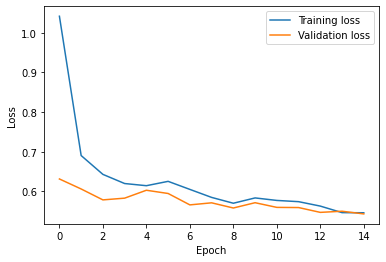

In [366]:
# Plot the training and validation loss over epochs
plt.plot(history4.history['loss'], label='Training loss')
plt.plot(history4.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

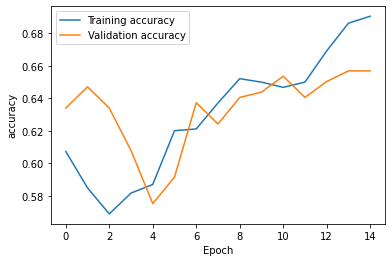

In [368]:
# Plot the training and validation loss over epochs
plt.plot(history4.history['accuracy'], label='Training accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [369]:
predictions = np.array([])
labels =  np.array([])
for x, y in train_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

3/3 [==============================] - 20s 7s/step


In [370]:
cm=tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

In [334]:
cm[0]

array([110,   2], dtype=int32)

In [371]:
df_cfm = pd.DataFrame(cm)
df_cfm=df_cfm.transpose()
df_cfm

,0,1
0,283,38
1,203,413


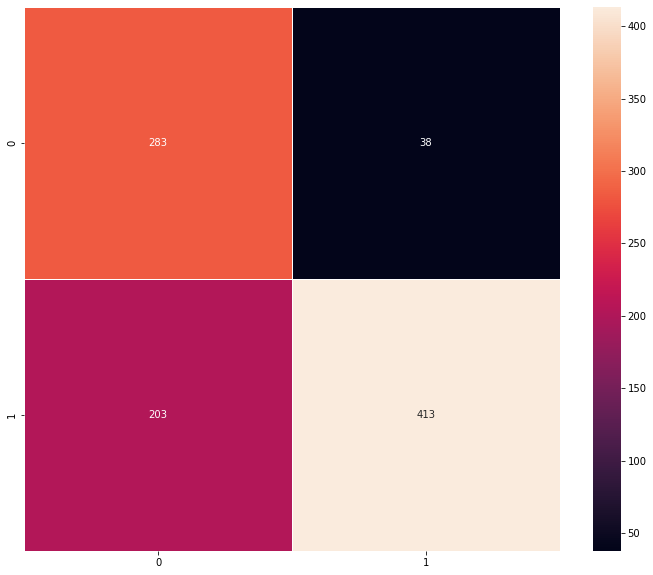

In [372]:
plt.figure(figsize = (12,10))
cfm_plot = sn.heatmap(df_cfm, annot=True, linewidths=.5, fmt='n')#, xticklabels=names_as_ints, yticklabels=names_as_ints)

In [373]:
predictions = np.array([])
labels =  np.array([])
for x, y in val_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

1/1 [==============================] - 6s 6s/step


In [374]:
cm=tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

In [375]:
cm[0]

array([82, 89], dtype=int32)

In [376]:
df_cfm = pd.DataFrame(cm)
df_cfm=df_cfm.transpose()
df_cfm

,0,1
0,82,16
1,89,119


---------
---------
---------
---------
---------
---------


### Add class weights to reduce false positives

In [405]:
class_weight={0: 1.3,
              1: 1.}

In [406]:
# Define image dimensions
img_height = 224
img_width = 224
input_shape = (img_height, img_width, 3)

# Set the seed validation
seed_train_validation = 2 # Must be same for train_ds and val_ds
shuffle_value = True # Must be same

# Number of classes
num_classes = 2 

# Set the path for the dataset
train_data_dir = '/Users/jonathanforsyth/Documents/UMass/Machine_Learning/spectra/images/train9/'
val_data_dir = '/Users/jonathanforsyth/Documents/UMass/Machine_Learning/spectra/images/validation9/'

In [407]:
# Training Dataset
train_ds = keras.utils.image_dataset_from_directory(directory=train_data_dir,
                                                    labels='inferred',
                                                    label_mode='categorical',
                                                    batch_size=94,
                                                    image_size=(img_height, img_width),
                                                    shuffle=shuffle_value, 
                                                    seed = seed_train_validation)

# Validation Dataset
val_ds = keras.utils.image_dataset_from_directory(directory=val_data_dir,
                                                    labels='inferred',
                                                    label_mode='categorical', 
                                                    batch_size=31,
                                                    image_size=(img_height, img_width),
                                                    shuffle=shuffle_value, 
                                                    seed = seed_train_validation)

Found 937 files belonging to 2 classes.
Found 306 files belonging to 2 classes.


In [408]:
# Build the final classification layers
model = tf.keras.models.Sequential([
    vgg16_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

In [409]:
model.load_weights(checkpoint_path)

In [410]:
# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [411]:
checkpoint_path = "spectra/images/checkpoints/cp2.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [412]:
# Train the model and store the history
history4 = model.fit(train_ds,
                     epochs=40,
                     validation_data=val_ds,
                     class_weight=class_weight,
                     callbacks=[cp_callback])

Epoch 1/40
10/10 [==============================] - ETA: 0s - loss: 0.6137 - accuracy: 0.5806 
Epoch 1: saving model to spectra/images/checkpoints/cp2.ckpt
10/10 [==============================] - 274s 28s/step - loss: 0.6137 - accuracy: 0.5806 - val_loss: 0.5308 - val_accuracy: 0.6209
Epoch 2/40
10/10 [==============================] - ETA: 0s - loss: 0.5873 - accuracy: 0.5827 
Epoch 2: saving model to spectra/images/checkpoints/cp2.ckpt
10/10 [==============================] - 265s 27s/step - loss: 0.5873 - accuracy: 0.5827 - val_loss: 0.5513 - val_accuracy: 0.6373
Epoch 3/40
10/10 [==============================] - ETA: 0s - loss: 0.5678 - accuracy: 0.5966 
Epoch 3: saving model to spectra/images/checkpoints/cp2.ckpt
10/10 [==============================] - 264s 27s/step - loss: 0.5678 - accuracy: 0.5966 - val_loss: 0.5421 - val_accuracy: 0.6275
Epoch 4/40
10/10 [==============================] - ETA: 0s - loss: 0.5777 - accuracy: 0.5977 
Epoch 4: saving model to spectra/images/chec

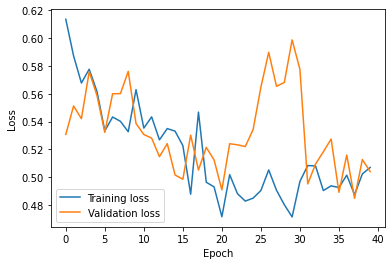

In [413]:
# Plot the training and validation loss over epochs
plt.plot(history4.history['loss'], label='Training loss')
plt.plot(history4.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

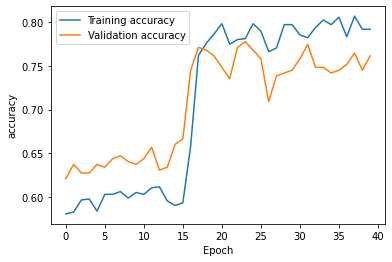

In [414]:
# Plot the training and validation loss over epochs
plt.plot(history4.history['accuracy'], label='Training accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [415]:
predictions = np.array([])
labels =  np.array([])
for x, y in train_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

3/3 [==============================] - 19s 6s/step


In [416]:
cm=tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

In [417]:
cm[0]

array([387,  99], dtype=int32)

In [418]:
df_cfm = pd.DataFrame(cm)
df_cfm=df_cfm.transpose()
df_cfm

,0,1
0,387,13
1,99,438


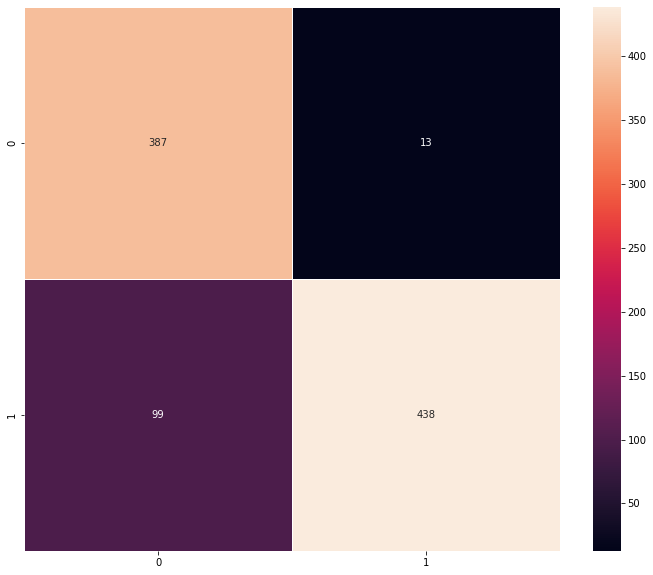

In [419]:
plt.figure(figsize = (12,10))
cfm_plot = sn.heatmap(df_cfm, annot=True, linewidths=.5, fmt='n')#, xticklabels=names_as_ints, yticklabels=names_as_ints)

In [420]:
predictions = np.array([])
labels =  np.array([])
for x, y in val_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

1/1 [==============================] - 5s 5s/step


In [421]:
cm=tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

In [422]:
cm[0]

array([104,  67], dtype=int32)

In [423]:
df_cfm = pd.DataFrame(cm)
df_cfm=df_cfm.transpose()
df_cfm

,0,1
0,104,6
1,67,129
